## CS441: Applied ML - HW 4

### Part 1: Model Complexity and Tree-based Regressors

One measure of a tree’s complexity is the maximum tree depth. Train tree, random forest, and boosted tree regressors on the temperature regression task, using all default parameters except:


*   max_depth={2,4,8,16,32}
*   random_state=0
*   For random forest: max_features=1/3

Measure train and val RMSE for each and plot them all on the same plot using the provided plot_depth_error function. You should have six lines (train/val for each model type), each with 5 data points (one for each max depth value).  Include the plot and answer the analysis questions in the report.

In [50]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

# load data (modify to match your data directory or comment)
def load_temp_data():
  datadir = "/Users/darian/Desktop/UIUC/Applied ML/HW4/Code/temperature_data.npz"
  T = np.load(datadir)
  x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# plot one data point for listed cities and target temperature
def plot_temps(x, y, cities, feature_to_city, feature_to_day, target_date):
  nc = len(cities)
  ndays = 5
  xplot = np.array([-5,-4,-3,-2,-1])
  yplot = np.zeros((nc,ndays))
  for f in np.arange(len(x)):
    for c in np.arange(nc):
      if cities[c]==feature_to_city[f]:
        yplot[feature_to_day[f]+ndays,c] = x[f]
  plt.plot(xplot,yplot)
  plt.legend(cities)
  plt.plot(0, y, 'b*', markersize=10)
  plt.title('Predict Temp for Cleveland on ' + target_date)
  plt.xlabel('Day')
  plt.ylabel('Avg Temp (C)')
  plt.show()

# load data
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()

In [51]:
# to plot the errors
def plot_depth_error(max_depths, tree_train_err, tree_val_err, rf_train_err, rf_val_err, bt_train_err, bt_val_err):
  plt.figure()
  plt.semilogx(max_depths, tree_train_err, 'r.--',label='tree train')
  plt.semilogx(max_depths, tree_val_err, 'r.-', label='tree val')
  plt.semilogx(max_depths, rf_train_err, 'g.--',label='RF train')
  plt.semilogx(max_depths, rf_val_err, 'g.-', label='RF val')
  plt.semilogx(max_depths, bt_train_err, 'b.--',label='BT train')
  plt.semilogx(max_depths, bt_val_err, 'b.-', label='BT val')
  plt.ylabel('RMSE Error')
  plt.xlabel('Max Tree Depth')
  plt.xticks(max_depths, max_depths)
  plt.legend()
  plt.rcParams.update({'font.size': 20})
  plt.show()

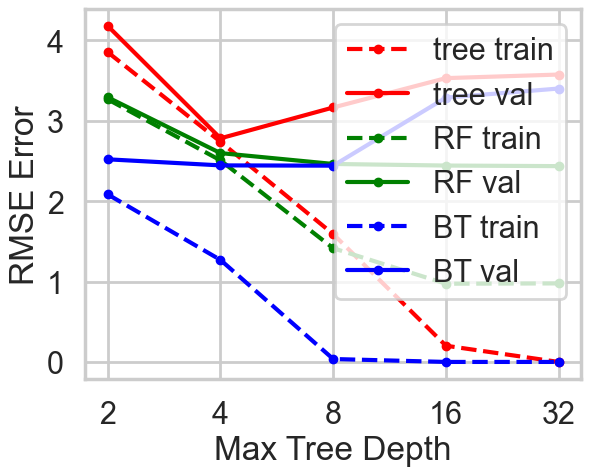

In [53]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

max_depths = [2,4,8,16,32]

tree_train_rmse, tree_val_rmse = [], []
rf_train_rmse, rf_val_rmse = [], []
bt_train_rmse, bt_val_rmse = [], []

for depth in max_depths:
    # Decision Tree
    tree_model = DecisionTreeRegressor(random_state=0, max_depth=depth)
    tree_model.fit(x_train, y_train)
    tree_train_rmse.append(np.sqrt(mean_squared_error(y_train, tree_model.predict(x_train))))
    tree_val_rmse.append(np.sqrt(mean_squared_error(y_val, tree_model.predict(x_val))))
    
    # Random Forest
    rf_model = RandomForestRegressor(random_state=0, max_depth=depth, max_features=1/3)
    rf_model.fit(x_train, y_train)
    rf_train_rmse.append(np.sqrt(mean_squared_error(y_train, rf_model.predict(x_train))))
    rf_val_rmse.append(np.sqrt(mean_squared_error(y_val, rf_model.predict(x_val))))
    
    # Boosted Trees
    bt_model = GradientBoostingRegressor(random_state=0, max_depth=depth)
    bt_model.fit(x_train, y_train)
    bt_train_rmse.append(np.sqrt(mean_squared_error(y_train, bt_model.predict(x_train))))
    bt_val_rmse.append(np.sqrt(mean_squared_error(y_val, bt_model.predict(x_val))))

plot_depth_error(max_depths, tree_train_rmse, tree_val_rmse, rf_train_rmse, rf_val_rmse, bt_train_rmse, bt_val_rmse)


### Part 2: MLPs with MNIST

For this part, you will want to use a GPU to improve runtime. Google Colab provides limited free GPU acceleration to all users. Go to Runtime and change Runtime Type to GPU.  This will reset your compute node, so do it before starting to run other cells.

See [Tips](https://docs.google.com/document/d/1_kV9x1LCAFfe6UqY22eqj2eqdCZh72oQDf60zRo2ydM/edit?usp=drive_link) for detailed guidance on this problem.

First, use PyTorch to implement a Multilayer Perceptron network with one hidden layer (size 64) with ReLU activation. Set the network to minimize cross-entropy loss, which is the negative log probability of the training labels given the training features. This objective function takes unnormalized logits as inputs.

*Do not use MLP in sklearn for this HW - use Torch*.

In [54]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
import torch
import torch.nn as nn

def load_mnist():
  '''
  Loads, reshapes, and normalizes the data
  '''
  (x_train, y_train), (x_test, y_test) = mnist.load_data() # loads MNIST data
  x_train = np.reshape(x_train, (len(x_train), 28*28))  # reformat to 768-d vectors
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval  # normalize values to range from 0 to 1
  x_test = x_test/maxval
  return (x_train, y_train), (x_test, y_test)

def display_mnist(x, subplot_rows=1, subplot_cols=1):
  '''
  Displays one or more examples in a row or a grid
  '''
  if subplot_rows>1 or subplot_cols>1:
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
    for i in np.arange(len(x)):
      ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
      ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

In [55]:

device = torch.device("mps")
print(device) # make sure you're using GPU instance

mps


#### 2a
Using the train/val split provided in the starter code, train your network for 100 epochs with learning rates of 0.01, 0.1, and 1.  Use a batch size of 256 and the SGD optimizer.  After each epoch, record the mean training and validation loss and compute the validation error of the final model. The mean validation loss should be computed after the epoch is complete.  The mean training loss can either be computed after the epoch is complete, or, for efficiency, computed using the losses accumulated during the training of the epoch.  Plot the training and validation losses using the display_error_curves function.

In [56]:
(x_train, y_train), (x_test, y_test) = load_mnist()

# create train/val split
ntrain = 50000
x_val = x_train[ntrain:].copy()
y_val = y_train[ntrain:].copy()
x_train = x_train[:ntrain]
y_train = y_train[:ntrain]

In [57]:


def display_error_curves(training_losses, validation_losses):
  """
  Plots the training and validation loss curves
  training_losses and validation_losses should be lists or arrays of the same length
  """
  num_epochs = len(training_losses)

  plt.plot(range(num_epochs), training_losses, label="Training Loss")
  plt.plot(range(num_epochs), validation_losses, label="Validation Loss")

  # Add in a title and axes labels
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  # Display the plot
  plt.legend(loc='best')
  plt.show()

In [58]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [59]:
from torch.utils.data import DataLoader, TensorDataset
import tqdm


# This is a possible function definition for training MLP, but feel free to change it
# You may also want to create helper functions, e.g. for computing loss or prediction

def train_MLP_mnist(train_loader, val_loader, lr, num_epochs=100):
  '''
  Train a MLP
  Input: train_loader and val_loader are dataloaders for the training and
  val data, respectively. lr is the learning rate, and the network will
  be trained for num_epochs epochs.
  Output: return a trained MLP
  '''
  # TODO: fill in all code

  input_size = 28*28
  hidden_size = 64
  output_size = 10

  mlp = MLP(input_size, output_size).to(device)
  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(mlp.parameters(), lr=lr)

  training_losses = []
  validation_losses = []

  for epoch in range(num_epochs):
      mlp.train()
      running_loss = 0.0
      for inputs, labels in tqdm.tqdm(train_loader):
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = mlp(inputs)
          loss = loss_func(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
      training_losses.append(running_loss / len(train_loader))

      mlp.eval()
      running_val_loss = 0.0
      with torch.no_grad():
          for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = mlp(inputs)
              val_loss = loss_func(outputs, labels)
              running_val_loss += val_loss.item()
      validation_losses.append(running_val_loss / len(val_loader))

  display_error_curves(training_losses, validation_losses)

  return mlp


def evaluate_MLP(mlp, loader):
  ''' Computes loss and error rate given your mlp model and data loader'''
  N = 0
  acc = 0
  running_loss = 0
  loss_func = torch.nn.CrossEntropyLoss()
  with torch.set_grad_enabled(False):
    for i, data in enumerate(loader, 0):

      # Get inputs
      inputs, targets = data
      N += len(targets)

      # Perform forward pass
      outputs = mlp(inputs.to(device))

      # Compute sum of correct labels
      y_pred = np.argmax(outputs.cpu().numpy(), axis=1)
      y_gt = targets.numpy()
      acc += np.sum(y_pred==y_gt)

      # Compute loss
      running_loss += loss_func(outputs, targets.to(device)).item()*len(targets)

  running_loss /= N
  acc /= N

  return running_loss, 1-acc


mps
Loss curve with lr: 0.001


100%|██████████| 196/196 [00:00<00:00, 298.12it/s]


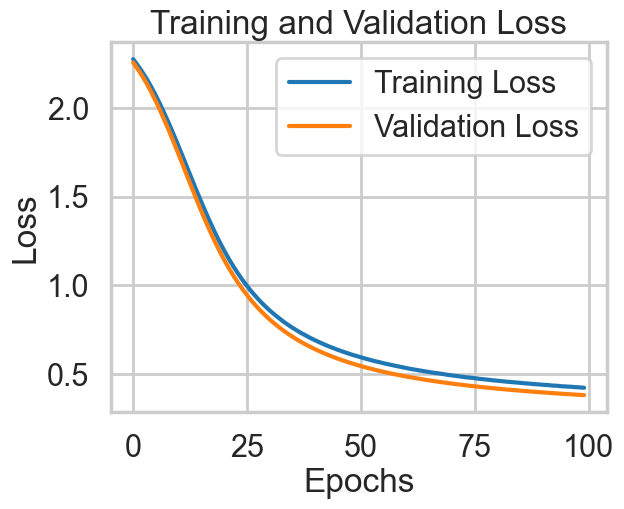

Loss curve with lr: 0.01


100%|██████████| 196/196 [00:00<00:00, 309.56it/s]


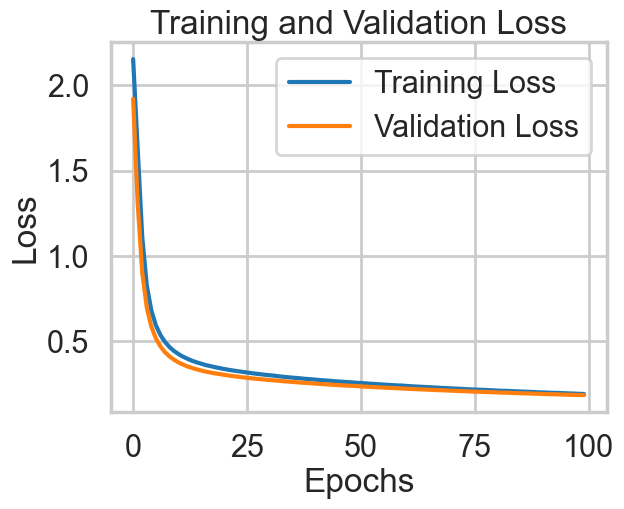

Loss curve with lr: 0.1


100%|██████████| 196/196 [00:00<00:00, 302.30it/s]


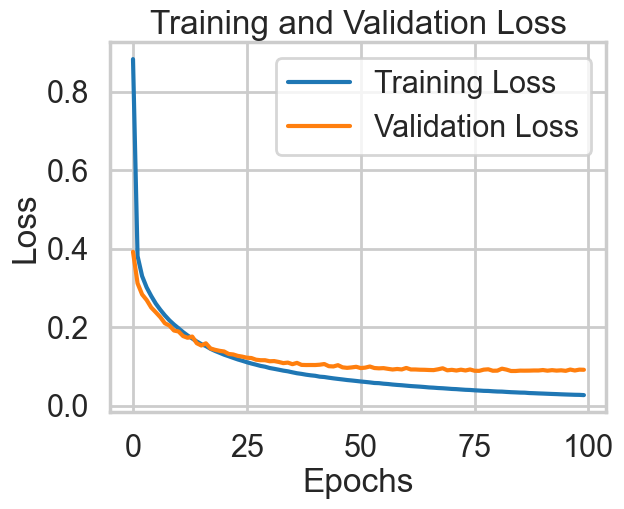

Loss curve with lr: 1.0


100%|██████████| 196/196 [00:00<00:00, 286.55it/s]


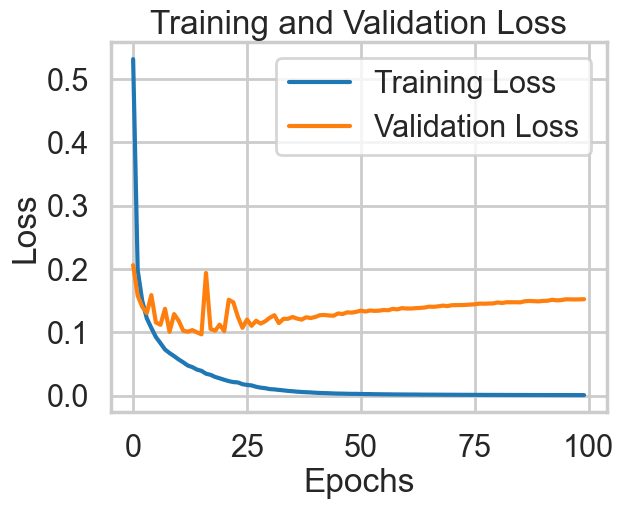

In [60]:
# Code for running experiments

print(device) # make sure you're using GPU instance
torch.manual_seed(0) # to avoid randomness, but if you wanted to create an ensemble, you should not use a manual seed

# TODO (set up dataloaders, and call training function)

device = torch.device("mps")

tensor_x_train = torch.FloatTensor(x_train)  # Assuming x_train is scaled [0, 1]
tensor_y_train = torch.LongTensor(y_train)
tensor_x_val = torch.FloatTensor(x_val)
tensor_y_val = torch.LongTensor(y_val)

# Convert test data to DataLoader
tensor_x_test = torch.FloatTensor(x_test)  
tensor_y_test = torch.LongTensor(y_test)
test_dataset = torch.utils.data.TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

train_dataset = torch.utils.data.TensorDataset(tensor_x_train, tensor_y_train)
val_dataset = torch.utils.data.TensorDataset(tensor_x_val, tensor_y_val)

train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=256, shuffle=False)

learning_rates = [0.001, 0.01, 0.1, 1.0]
for lr in learning_rates:
  print(f"Loss curve with lr: {lr}")
  train_MLP_mnist(train_loader, val_loader, lr=lr, num_epochs=100)




#### 2b
Based on the loss curves, select the learning rate and number of epochs that minimizes the validation loss.  Retrain that model (if it's not stored), and report training loss, validation loss, training error, validation error, and test error.

100%|██████████| 196/196 [00:00<00:00, 305.25it/s]


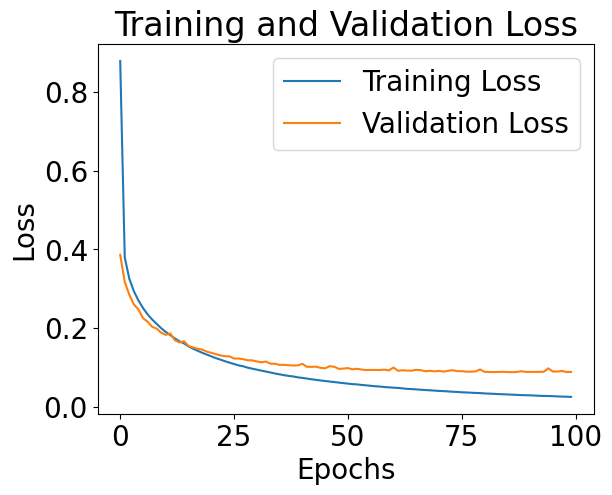

Training Loss: 0.02437850608408451, Training Error: 0.0043600000000000305
Validation Loss: 0.09121068652272224, Validation Error: 0.026699999999999946
Test Loss: 0.08075617408510298, Test Error: 0.02429999999999999


In [ ]:

mlp = train_MLP_mnist(train_loader, val_loader, lr=0.1, num_epochs=100)

train_loss, train_error = evaluate_MLP(mlp, train_loader)
val_loss, val_error = evaluate_MLP(mlp, val_loader)
test_loss, test_error = evaluate_MLP(mlp, test_loader)

print(f"Training Loss: {train_loss}, Training Error: {train_error}")
print(f"Validation Loss: {val_loss}, Validation Error: {val_error}")
print(f"Test Loss: {test_loss}, Test Error: {test_error}")

## Part 3: Predicting Penguin Species

Include all your code for part 3 in this section.  

In [ ]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
#styling preferences for sns
sns.set_style('whitegrid')
sns.set_context('poster')
datadir = datadir = "/Users/darian/Desktop/UIUC/Applied ML/HW4/Code/penguins_size.csv" # TO DO: modify this to your directory
df_penguins = pd.read_csv(datadir)
df_penguins.head(10)

# convert features with multiple string values to binary features so they can be used by sklearn
def get_penguin_xy(df_penguins):
  data = np.array(df_penguins[['island', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']])
  y = df_penguins['species']
  ui = np.unique(data[:,0]) # unique island
  us = np.unique(data[:,-1]) # unique sex
  X = np.zeros((len(y), 10))
  for i in range(len(y)):
    f = 0
    for j in range(len(ui)):
      if data[i, f]==ui[j]:
        X[i, f+j] = 1
    f = f + len(ui)
    X[i, f:(f+4)] = data[i, 1:5]
    f=f+4
    for j in range(len(us)):
      if data[i, 5]==us[j]:
        X[i, f+j] = 1
  feature_names = ['island_biscoe', 'island_dream', 'island_torgersen', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex_female', 'sex_male', 'sex_unknown']
  X = pd.DataFrame(X, columns=feature_names)
  return(X, y, feature_names, np.unique(y))

#### 3a
Spend some time to visualize different pairs of features and their relationships to the species.  We’ve done one for you.  Include in your report at least two other visualizations.

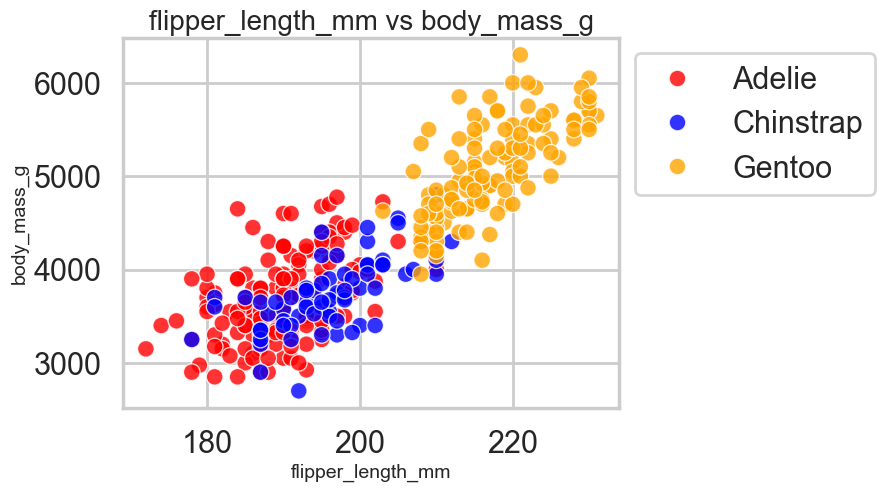

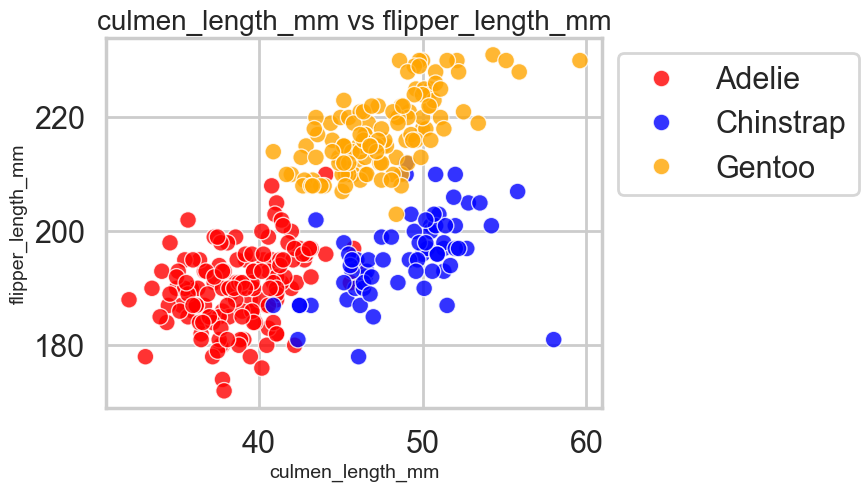

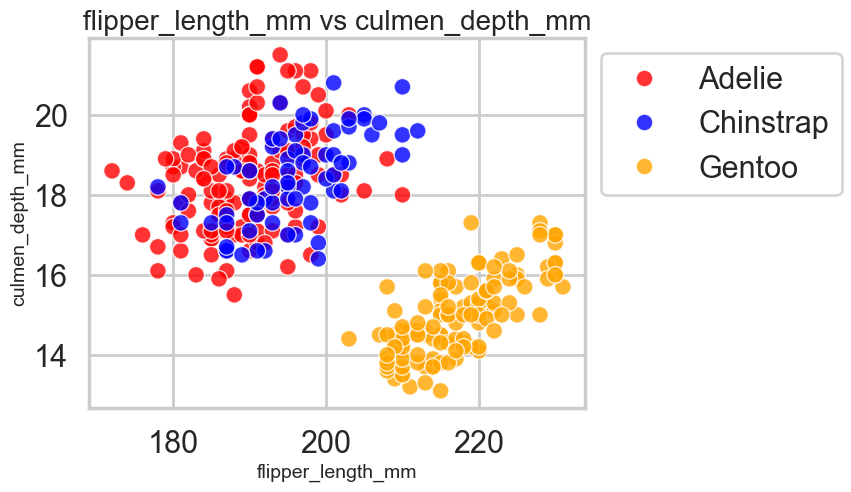

In [ ]:
def plot_scatter(feature1, feature2):
  '''
  Provide names of two features to create a scatterplot of them
  E.g. plot_scatter('culmen_length_mm', 'culmen_depth_mm')
  Possible features: 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g'
  '''

  palette = ["red", "blue", "orange"]

  sns.scatterplot(data=df_penguins, x = feature1, y = feature2,
               hue = 'species', palette=palette, alpha=0.8)
  # Doc: https://seaborn.pydata.org/generated/seaborn.scatterplot.html

  plt.xlabel(feature1, fontsize=14)
  plt.ylabel(feature2, fontsize=14)
  plt.title(feature1 + ' vs ' + feature2, fontsize=20)
  plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
  plt.show()

# TO DO call plot_scatter with different feature pairs to create some visualizations

plot_scatter('flipper_length_mm', 'body_mass_g')
plot_scatter('culmen_length_mm', 'flipper_length_mm')
plot_scatter('flipper_length_mm', 'culmen_depth_mm')


#### 3b
Suppose you want to be able to identify the Gentoo species with a simple rule with very high accuracy.  Use a decision tree classifier to figure out such a rule that has only two checks (e.g. “mass greater than 4000 g, and culmen length less than 40 mm is Gentoo; otherwise, not”).   You can use the library DecisionTreeClassifier with either ‘gini’ or ‘entropy’ criterion. Use sklearn.tree.plot_tree with feature_names and class_names arguments to visualize the decision tree.  Include the tree that you used to find the rule in your report and the rule.

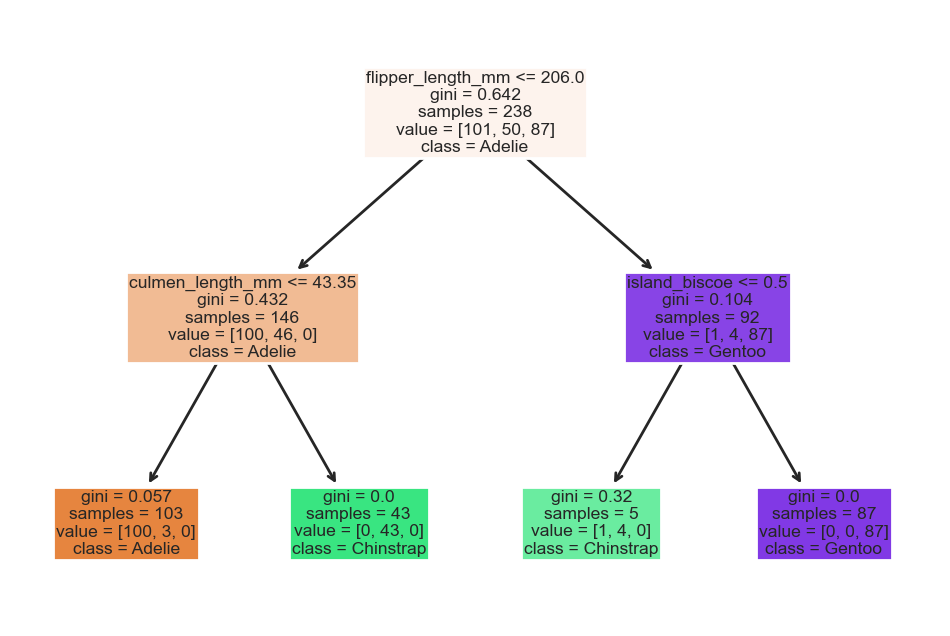

Precision: 0.8949065119277885
Recall: 0.9201058201058201


In [ ]:
# TO DO (Train a short tree to identify a good rule, plot the tree, report the rule and its precision/recall in your report)

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split

# get_penguin_xy is defined and returns X, y, feature_names, class_names
X, y, feature_names, class_names = get_penguin_xy(df_penguins)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the classifier
clf = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=42)
clf.fit(X_train, y_train)

# Visualize the tree
plt.figure(figsize=(12,8))
plot_tree(clf, filled=True, feature_names=feature_names, class_names=class_names)
plt.show()

y_pred = clf.predict(X_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")


#### 3c

Use any method at your disposal to achieve maximum 5-fold cross-validation accuracy on this problem. To keep it simple, we will use sklearn.model_selection to perform the cross-validation for us. Report your model design and 5-fold accuracy.  It is possible to get more than 99% accuracy.

In [ ]:
# design a classification model, import libraries as needed
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

X, y, feature_names, class_names = get_penguin_xy(df_penguins)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# TO DO -- choose some model and fit the data
model = RandomForestClassifier()
model.fit(X_train, y_train)

scores = cross_val_score(model, np.array(X), np.array(y), cv=5)
print('CV Accuracy: {}'.format(scores.mean()))

CV Accuracy: 0.9941176470588236


## Part 4: Stretch Goals
Include any new code needed for Part 4 here

#### 4a


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import tqdm

class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Second hidden layer
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # Third hidden layer
        self.relu3 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc5(x)
        return x


def train_MLP_mnist(train_loader, val_loader, lr, num_epochs):
  '''
  Train a MLP
  Input: train_loader and val_loader are dataloaders for the training and
  val data, respectively. lr is the learning rate, and the network will
  be trained for num_epochs epochs.
  Output: return a trained MLP
  '''
  # TODO: fill in all code

  input_size = 28*28
  hidden_size = 128
  output_size = 10

  mlp = MLP(input_size, output_size).to(device)
  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)

  training_losses = []
  validation_losses = []

  for epoch in range(num_epochs):
      mlp.train()
      running_loss = 0.0
      for inputs, labels in tqdm.tqdm(train_loader):
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = mlp(inputs)
          loss = loss_func(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
      training_losses.append(running_loss / len(train_loader))

      mlp.eval()
      running_val_loss = 0.0
      with torch.no_grad():
          for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = mlp(inputs)
              val_loss = loss_func(outputs, labels)
              running_val_loss += val_loss.item()
      validation_losses.append(running_val_loss / len(val_loader))

  return mlp


device = torch.device("mps")

tensor_x_train = torch.FloatTensor(x_train)  
tensor_y_train = torch.LongTensor(y_train)
tensor_x_val = torch.FloatTensor(x_val)
tensor_y_val = torch.LongTensor(y_val)

# Convert test data to DataLoader
tensor_x_test = torch.FloatTensor(x_test)  
tensor_y_test = torch.LongTensor(y_test)
test_dataset = torch.utils.data.TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

train_dataset = torch.utils.data.TensorDataset(tensor_x_train, tensor_y_train)
val_dataset = torch.utils.data.TensorDataset(tensor_x_val, tensor_y_val)

train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=256, shuffle=False)


# Evaluation

mlp = train_MLP_mnist(train_loader, val_loader, lr=0.001, num_epochs=300)

train_loss, train_error = evaluate_MLP(mlp, train_loader)
val_loss, val_error = evaluate_MLP(mlp, val_loader)
test_loss, test_error = evaluate_MLP(mlp, test_loader)

print(f"Training Loss: {train_loss}, Training Error: {train_error}")
print(f"Validation Loss: {val_loss}, Validation Error: {val_error}")
print(f"Test Loss: {test_loss}, Test Error: {test_error}")



100%|██████████| 196/196 [00:00<00:00, 199.75it/s]


Training Loss: 5.245208427595571e-11, Training Error: 0.0
Validation Loss: 0.2797041184850037, Validation Error: 0.019399999999999973
Test Loss: 0.26092285749805977, Test Error: 0.01859999999999995


#### 4b


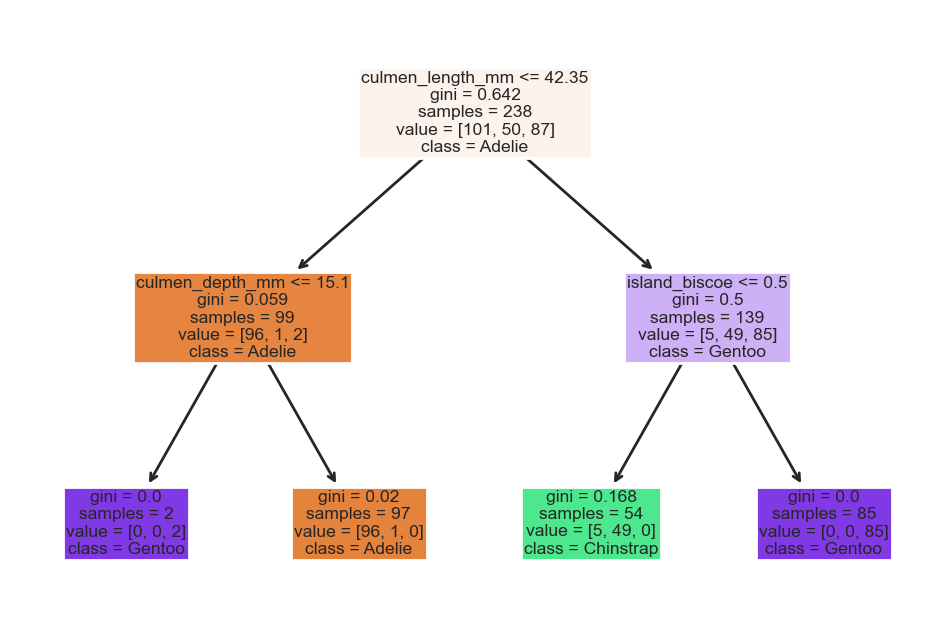

Precision: 0.9130781499202553
Recall: 0.9533333333333333


In [ ]:
# TO DO (Train a short tree to identify a good rule, plot the tree, report the rule and its precision/recall in your report)

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split

def get_penguin_xy_modified(df_penguins):
    # Select features excluding 'flipper_length_mm' and 'island_biscoe'
    selected_features = ['island', 'culmen_length_mm', 'culmen_depth_mm', 'body_mass_g', 'sex']
    data = np.array(df_penguins[selected_features])
    y = df_penguins['species']
    

    ui = np.unique(data[:,0])  
    us = np.unique(data[:,-1]) 
    X = []
    feature_names = []
    
    for feature in selected_features:
        if feature == 'island':
            for island in ui:
                X.append((data[:, 0] == island).astype(float))
                feature_names.append(f'island_{island.lower()}')
        elif feature == 'sex':
            for sex in us:
                X.append((data[:, -1] == sex).astype(float))
                feature_names.append(f'sex_{sex.lower()}')
        else:
            X.append(data[:, selected_features.index(feature)].astype(float))
            feature_names.append(feature)
    
    X = np.array(X).T  # Transpose to get correct shape
    return pd.DataFrame(X, columns=feature_names), y, feature_names, np.unique(y)


# get_penguin_xy is defined and returns X, y, feature_names, class_names
X, y, feature_names, class_names = get_penguin_xy_modified(df_penguins)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the classifier
clf = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=42)
clf.fit(X_train, y_train)

# Visualize the tree
plt.figure(figsize=(12,8))
plot_tree(clf, filled=True, feature_names=feature_names, class_names=class_names)
plt.show()

y_pred = clf.predict(X_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")


#### 4c


Corrupt JPEG data: premature end of data segment
100%|██████████| 16/16 [00:00<00:00, 188.32it/s]


Epoch 1, Loss: 6.361784530803561


100%|██████████| 16/16 [00:00<00:00, 220.27it/s]


Epoch 2, Loss: 0.097307488322258


100%|██████████| 16/16 [00:00<00:00, 199.98it/s]


Epoch 3, Loss: 0.0809036330319941


100%|██████████| 16/16 [00:00<00:00, 212.88it/s]


Epoch 4, Loss: 0.06743407342582941


100%|██████████| 16/16 [00:00<00:00, 232.40it/s]


Epoch 5, Loss: 0.045191442826762795


100%|██████████| 16/16 [00:00<00:00, 219.21it/s]


Epoch 6, Loss: 0.02667774073779583


100%|██████████| 16/16 [00:00<00:00, 228.22it/s]


Epoch 7, Loss: 0.01827424461953342


100%|██████████| 16/16 [00:00<00:00, 199.41it/s]


Epoch 8, Loss: 0.015216938685625792


100%|██████████| 16/16 [00:00<00:00, 192.17it/s]


Epoch 9, Loss: 0.013051668822299689


100%|██████████| 16/16 [00:00<00:00, 191.99it/s]


Epoch 10, Loss: 0.012649160344153643


100%|██████████| 16/16 [00:00<00:00, 207.00it/s]


Epoch 11, Loss: 0.011387166276108474


100%|██████████| 16/16 [00:00<00:00, 197.43it/s]


Epoch 12, Loss: 0.010711078299209476


100%|██████████| 16/16 [00:00<00:00, 195.03it/s]


Epoch 13, Loss: 0.010303294577170163


100%|██████████| 16/16 [00:00<00:00, 193.80it/s]


Epoch 14, Loss: 0.009952390450052917


100%|██████████| 16/16 [00:00<00:00, 205.96it/s]


Epoch 15, Loss: 0.011147551645990461


100%|██████████| 16/16 [00:00<00:00, 195.57it/s]


Epoch 16, Loss: 0.0112522131530568


100%|██████████| 16/16 [00:00<00:00, 167.08it/s]


Epoch 17, Loss: 0.010854602151084691


100%|██████████| 16/16 [00:00<00:00, 192.80it/s]


Epoch 18, Loss: 0.010540967661654577


100%|██████████| 16/16 [00:00<00:00, 208.47it/s]


Epoch 19, Loss: 0.009570124180754647


100%|██████████| 16/16 [00:00<00:00, 198.59it/s]


Epoch 20, Loss: 0.010738790704635903


100%|██████████| 16/16 [00:00<00:00, 201.40it/s]


Epoch 21, Loss: 0.00935573864262551


100%|██████████| 16/16 [00:00<00:00, 210.05it/s]


Epoch 22, Loss: 0.009115268563618883


100%|██████████| 16/16 [00:00<00:00, 61.78it/s]


Epoch 23, Loss: 0.009372417465783656


100%|██████████| 16/16 [00:00<00:00, 215.87it/s]


Epoch 24, Loss: 0.008732812915695831


100%|██████████| 16/16 [00:00<00:00, 228.49it/s]


Epoch 25, Loss: 0.010380744119174778


100%|██████████| 16/16 [00:00<00:00, 217.83it/s]


Epoch 26, Loss: 0.008944785891799256


100%|██████████| 16/16 [00:00<00:00, 218.92it/s]


Epoch 27, Loss: 0.0084190811321605


100%|██████████| 16/16 [00:00<00:00, 201.70it/s]


Epoch 28, Loss: 0.008956389909144491


100%|██████████| 16/16 [00:00<00:00, 204.27it/s]


Epoch 29, Loss: 0.008274462801637128


100%|██████████| 16/16 [00:00<00:00, 198.86it/s]


Epoch 30, Loss: 0.008419048186624423


100%|██████████| 16/16 [00:00<00:00, 208.37it/s]


Epoch 31, Loss: 0.008142507140291855


100%|██████████| 16/16 [00:00<00:00, 192.07it/s]


Epoch 32, Loss: 0.008606362505815923


100%|██████████| 16/16 [00:00<00:00, 202.26it/s]


Epoch 33, Loss: 0.008288185490528122


100%|██████████| 16/16 [00:00<00:00, 203.35it/s]


Epoch 34, Loss: 0.008960920182289556


100%|██████████| 16/16 [00:00<00:00, 206.54it/s]


Epoch 35, Loss: 0.009341183729702607


100%|██████████| 16/16 [00:00<00:00, 209.76it/s]


Epoch 36, Loss: 0.008809537219349295


100%|██████████| 16/16 [00:00<00:00, 202.63it/s]


Epoch 37, Loss: 0.009522159263724461


100%|██████████| 16/16 [00:00<00:00, 206.79it/s]


Epoch 38, Loss: 0.009635431750211865


100%|██████████| 16/16 [00:00<00:00, 205.87it/s]


Epoch 39, Loss: 0.009435738786123693


100%|██████████| 16/16 [00:00<00:00, 205.65it/s]


Epoch 40, Loss: 0.009203622554196045


100%|██████████| 16/16 [00:00<00:00, 199.67it/s]


Epoch 41, Loss: 0.010180779208894819


100%|██████████| 16/16 [00:00<00:00, 203.30it/s]


Epoch 42, Loss: 0.011082793062087148


100%|██████████| 16/16 [00:00<00:00, 200.49it/s]


Epoch 43, Loss: 0.010989781585521996


100%|██████████| 16/16 [00:00<00:00, 205.62it/s]


Epoch 44, Loss: 0.008480481541482732


100%|██████████| 16/16 [00:00<00:00, 205.63it/s]


Epoch 45, Loss: 0.009463638765737414


100%|██████████| 16/16 [00:00<00:00, 199.69it/s]


Epoch 46, Loss: 0.008382301282836124


100%|██████████| 16/16 [00:00<00:00, 204.78it/s]


Epoch 47, Loss: 0.00843328531482257


100%|██████████| 16/16 [00:00<00:00, 197.46it/s]


Epoch 48, Loss: 0.00811191156390123


100%|██████████| 16/16 [00:00<00:00, 207.14it/s]


Epoch 49, Loss: 0.007896206399891526


100%|██████████| 16/16 [00:00<00:00, 207.95it/s]


Epoch 50, Loss: 0.0081322648038622


100%|██████████| 16/16 [00:00<00:00, 205.67it/s]


Epoch 51, Loss: 0.007888395164627582


100%|██████████| 16/16 [00:00<00:00, 204.49it/s]


Epoch 52, Loss: 0.008071227493928745


100%|██████████| 16/16 [00:00<00:00, 197.79it/s]


Epoch 53, Loss: 0.00820178521098569


100%|██████████| 16/16 [00:00<00:00, 221.77it/s]


Epoch 54, Loss: 0.008987139270175248


100%|██████████| 16/16 [00:00<00:00, 228.34it/s]


Epoch 55, Loss: 0.007986910175532103


100%|██████████| 16/16 [00:00<00:00, 224.06it/s]


Epoch 56, Loss: 0.008050669392105192


100%|██████████| 16/16 [00:00<00:00, 217.79it/s]


Epoch 57, Loss: 0.00932959938654676


100%|██████████| 16/16 [00:00<00:00, 200.92it/s]


Epoch 58, Loss: 0.008483249170240015


100%|██████████| 16/16 [00:00<00:00, 199.59it/s]


Epoch 59, Loss: 0.008111564413411543


100%|██████████| 16/16 [00:00<00:00, 194.92it/s]


Epoch 60, Loss: 0.008459593402221799


100%|██████████| 16/16 [00:00<00:00, 202.27it/s]


Epoch 61, Loss: 0.008719492703676224


100%|██████████| 16/16 [00:00<00:00, 186.66it/s]


Epoch 62, Loss: 0.009484018140938133


100%|██████████| 16/16 [00:00<00:00, 186.18it/s]


Epoch 63, Loss: 0.009026494197314605


100%|██████████| 16/16 [00:00<00:00, 190.31it/s]


Epoch 64, Loss: 0.00796593283303082


100%|██████████| 16/16 [00:00<00:00, 208.06it/s]


Epoch 65, Loss: 0.007591896486701444


100%|██████████| 16/16 [00:00<00:00, 213.87it/s]


Epoch 66, Loss: 0.007467301446013153


100%|██████████| 16/16 [00:00<00:00, 219.10it/s]


Epoch 67, Loss: 0.007954114931635559


100%|██████████| 16/16 [00:00<00:00, 224.52it/s]


Epoch 68, Loss: 0.008082072337856516


100%|██████████| 16/16 [00:00<00:00, 224.52it/s]


Epoch 69, Loss: 0.007583627593703568


100%|██████████| 16/16 [00:00<00:00, 223.61it/s]


Epoch 70, Loss: 0.007686958910198882


100%|██████████| 16/16 [00:00<00:00, 185.47it/s]


Epoch 71, Loss: 0.007685759483138099


100%|██████████| 16/16 [00:00<00:00, 180.76it/s]


Epoch 72, Loss: 0.008446847466984764


100%|██████████| 16/16 [00:00<00:00, 187.85it/s]


Epoch 73, Loss: 0.00860230956459418


100%|██████████| 16/16 [00:00<00:00, 192.94it/s]


Epoch 74, Loss: 0.008441139798378572


100%|██████████| 16/16 [00:00<00:00, 198.67it/s]


Epoch 75, Loss: 0.007757306972052902


100%|██████████| 16/16 [00:00<00:00, 202.90it/s]


Epoch 76, Loss: 0.007526073197368532


100%|██████████| 16/16 [00:00<00:00, 200.53it/s]


Epoch 77, Loss: 0.008193433604901657


100%|██████████| 16/16 [00:00<00:00, 190.81it/s]


Epoch 78, Loss: 0.009781566390302032


100%|██████████| 16/16 [00:00<00:00, 201.12it/s]


Epoch 79, Loss: 0.009191225748509169


100%|██████████| 16/16 [00:00<00:00, 193.54it/s]


Epoch 80, Loss: 0.008183842845028266


100%|██████████| 16/16 [00:00<00:00, 214.58it/s]


Epoch 81, Loss: 0.0075587735045701265


100%|██████████| 16/16 [00:00<00:00, 137.72it/s]


Epoch 82, Loss: 0.007837706798454747


100%|██████████| 16/16 [00:00<00:00, 175.75it/s]


Epoch 83, Loss: 0.0076701625948771834


100%|██████████| 16/16 [00:00<00:00, 183.43it/s]


Epoch 84, Loss: 0.008433665876509622


100%|██████████| 16/16 [00:00<00:00, 154.51it/s]


Epoch 85, Loss: 0.009516505291685462


100%|██████████| 16/16 [00:00<00:00, 215.86it/s]


Epoch 86, Loss: 0.009190075128572062


100%|██████████| 16/16 [00:00<00:00, 216.37it/s]


Epoch 87, Loss: 0.00943646498490125


100%|██████████| 16/16 [00:00<00:00, 178.68it/s]


Epoch 88, Loss: 0.009109929582336918


100%|██████████| 16/16 [00:00<00:00, 175.02it/s]


Epoch 89, Loss: 0.008112141076708212


100%|██████████| 16/16 [00:00<00:00, 194.47it/s]


Epoch 90, Loss: 0.008268574747489765


100%|██████████| 16/16 [00:00<00:00, 195.86it/s]


Epoch 91, Loss: 0.008823067706543952


100%|██████████| 16/16 [00:00<00:00, 200.68it/s]


Epoch 92, Loss: 0.007864415092626587


100%|██████████| 16/16 [00:00<00:00, 208.11it/s]


Epoch 93, Loss: 0.0077420717279892415


100%|██████████| 16/16 [00:00<00:00, 199.68it/s]


Epoch 94, Loss: 0.0086943804344628


100%|██████████| 16/16 [00:00<00:00, 198.53it/s]


Epoch 95, Loss: 0.009057783696334809


100%|██████████| 16/16 [00:00<00:00, 213.43it/s]


Epoch 96, Loss: 0.008273055602330714


100%|██████████| 16/16 [00:00<00:00, 226.82it/s]


Epoch 97, Loss: 0.007772155193379149


100%|██████████| 16/16 [00:00<00:00, 225.66it/s]


Epoch 98, Loss: 0.0076892363431397825


100%|██████████| 16/16 [00:00<00:00, 227.89it/s]


Epoch 99, Loss: 0.007563946273876354


100%|██████████| 16/16 [00:00<00:00, 229.02it/s]


Epoch 100, Loss: 0.007868390064686537


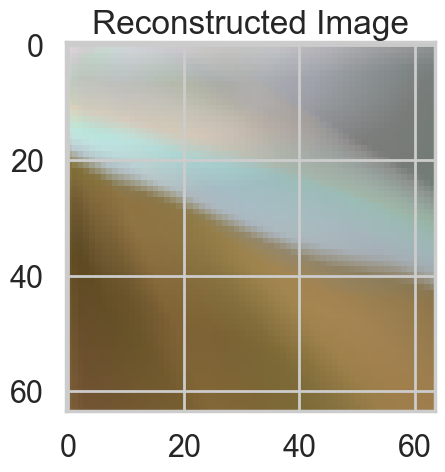

In [62]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import cv2
import matplotlib.pyplot as plt


class MLP(nn.Module):
    def __init__(self, input_size=2, output_size=3, hidden_size=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x


def train_MLP_RGB(train_loader, lr, num_epochs):
  '''
  Train a MLP
  Input: train_loader and val_loader are dataloaders for the training and
  val data, respectively. lr is the learning rate, and the network will
  be trained for num_epochs epochs.
  Output: return a trained MLP
  '''
  # TODO: fill in all code

  input_size = 2    # xy coord
  hidden_size = 128
  output_size = 3   # RGB vals

  mlp = MLP(input_size, output_size).to(device)
  loss_func = nn.MSELoss()
  optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)

  training_losses = []
  validation_losses = []

  for epoch in range(num_epochs):
      mlp.train()
      running_loss = 0.0
      for inputs, labels in tqdm.tqdm(train_loader):
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = mlp(inputs)
          loss = loss_func(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
      print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

  return mlp

device = torch.device("mps")

# Load image

datadir = "/Users/darian/Desktop/UIUC/Applied ML/HW4/Code/"
im = cv2.imread(datadir + 'scotland_photo_resized.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = im / 255.0  # Normalize to [0, 1]

# Prepare dataset
h, w, _ = im.shape
X = np.array([(x, y) for x in range(w) for y in range(h)])
y = im.reshape(-1, 3)
tensor_x = torch.FloatTensor(X)
tensor_y = torch.FloatTensor(y)
dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)


# Train the model
mlp = train_MLP_RGB(train_loader, lr=0.01, num_epochs=100)


# Predict and reconstruct image
mlp.eval()
with torch.no_grad():
    pred = mlp(tensor_x.to(device)).cpu().numpy()
pred_img = pred.reshape(h, w, 3)

# Display the reconstructed image
plt.imshow(pred_img)
plt.title("Reconstructed Image")
plt.show()

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
100%|██████████| 16/16 [00:00<00:00, 142.35it/s]


Epoch 1, Loss: 14.423560287803411


100%|██████████| 16/16 [00:00<00:00, 114.97it/s]


Epoch 2, Loss: 0.10160766169428825


100%|██████████| 16/16 [00:00<00:00, 160.48it/s]


Epoch 3, Loss: 0.08556164475157857


100%|██████████| 16/16 [00:00<00:00, 181.80it/s]


Epoch 4, Loss: 0.07205577474087477


100%|██████████| 16/16 [00:00<00:00, 184.31it/s]


Epoch 5, Loss: 0.061823243740946054


100%|██████████| 16/16 [00:00<00:00, 184.66it/s]


Epoch 6, Loss: 0.03410824591992423


100%|██████████| 16/16 [00:00<00:00, 187.83it/s]


Epoch 7, Loss: 0.02695615030825138


100%|██████████| 16/16 [00:00<00:00, 198.96it/s]


Epoch 8, Loss: 0.01734648074489087


100%|██████████| 16/16 [00:00<00:00, 201.15it/s]


Epoch 9, Loss: 0.01781691424548626


100%|██████████| 16/16 [00:00<00:00, 186.46it/s]


Epoch 10, Loss: 0.015590749972034246


100%|██████████| 16/16 [00:00<00:00, 197.06it/s]


Epoch 11, Loss: 0.012203400721773505


100%|██████████| 16/16 [00:00<00:00, 187.70it/s]


Epoch 12, Loss: 0.011773256992455572


100%|██████████| 16/16 [00:00<00:00, 182.48it/s]


Epoch 13, Loss: 0.013155062508303672


100%|██████████| 16/16 [00:00<00:00, 192.03it/s]


Epoch 14, Loss: 0.012057868647389114


100%|██████████| 16/16 [00:00<00:00, 194.10it/s]


Epoch 15, Loss: 0.011281624902039766


100%|██████████| 16/16 [00:00<00:00, 196.04it/s]


Epoch 16, Loss: 0.010967697540763766


100%|██████████| 16/16 [00:00<00:00, 190.69it/s]


Epoch 17, Loss: 0.01100812287768349


100%|██████████| 16/16 [00:00<00:00, 189.99it/s]


Epoch 18, Loss: 0.01099514018278569


100%|██████████| 16/16 [00:00<00:00, 193.52it/s]


Epoch 19, Loss: 0.011205404764041305


100%|██████████| 16/16 [00:00<00:00, 194.90it/s]


Epoch 20, Loss: 0.011863988009281456


100%|██████████| 16/16 [00:00<00:00, 201.79it/s]


Epoch 21, Loss: 0.012317969521973282


100%|██████████| 16/16 [00:00<00:00, 193.47it/s]


Epoch 22, Loss: 0.011286559572909027


100%|██████████| 16/16 [00:00<00:00, 192.27it/s]


Epoch 23, Loss: 0.012705707049462944


100%|██████████| 16/16 [00:00<00:00, 189.74it/s]


Epoch 24, Loss: 0.012097482627723366


100%|██████████| 16/16 [00:00<00:00, 187.69it/s]


Epoch 25, Loss: 0.010933726676739752


100%|██████████| 16/16 [00:00<00:00, 162.84it/s]


Epoch 26, Loss: 0.011539758008439094


100%|██████████| 16/16 [00:00<00:00, 197.57it/s]


Epoch 27, Loss: 0.012314148887526244


100%|██████████| 16/16 [00:00<00:00, 197.87it/s]


Epoch 28, Loss: 0.01186735660303384


100%|██████████| 16/16 [00:00<00:00, 202.27it/s]


Epoch 29, Loss: 0.010707817738875747


100%|██████████| 16/16 [00:00<00:00, 188.95it/s]


Epoch 30, Loss: 0.010445731168147177


100%|██████████| 16/16 [00:00<00:00, 200.89it/s]


Epoch 31, Loss: 0.010984132124576718


100%|██████████| 16/16 [00:00<00:00, 196.85it/s]


Epoch 32, Loss: 0.00969187804730609


100%|██████████| 16/16 [00:00<00:00, 207.36it/s]


Epoch 33, Loss: 0.009702716575702652


100%|██████████| 16/16 [00:00<00:00, 197.54it/s]


Epoch 34, Loss: 0.009996577224228531


100%|██████████| 16/16 [00:00<00:00, 201.91it/s]


Epoch 35, Loss: 0.009466655843425542


100%|██████████| 16/16 [00:00<00:00, 206.27it/s]


Epoch 36, Loss: 0.009528560854960233


100%|██████████| 16/16 [00:00<00:00, 197.45it/s]


Epoch 37, Loss: 0.00938967993715778


100%|██████████| 16/16 [00:00<00:00, 190.07it/s]


Epoch 38, Loss: 0.009345556260086596


100%|██████████| 16/16 [00:00<00:00, 199.35it/s]


Epoch 39, Loss: 0.009145722491666675


100%|██████████| 16/16 [00:00<00:00, 195.79it/s]


Epoch 40, Loss: 0.010130272916285321


100%|██████████| 16/16 [00:00<00:00, 194.55it/s]


Epoch 41, Loss: 0.06833726284094155


100%|██████████| 16/16 [00:00<00:00, 202.35it/s]


Epoch 42, Loss: 0.02618548332247883


100%|██████████| 16/16 [00:00<00:00, 190.78it/s]


Epoch 43, Loss: 0.015131795895285904


100%|██████████| 16/16 [00:00<00:00, 194.07it/s]


Epoch 44, Loss: 0.012962484906893224


100%|██████████| 16/16 [00:00<00:00, 203.47it/s]


Epoch 45, Loss: 0.012221925717312843


100%|██████████| 16/16 [00:00<00:00, 192.85it/s]


Epoch 46, Loss: 0.010790209111291915


100%|██████████| 16/16 [00:00<00:00, 195.37it/s]


Epoch 47, Loss: 0.010211617860477418


100%|██████████| 16/16 [00:00<00:00, 200.87it/s]


Epoch 48, Loss: 0.00983813765924424


100%|██████████| 16/16 [00:00<00:00, 191.50it/s]


Epoch 49, Loss: 0.009667583188274875


100%|██████████| 16/16 [00:00<00:00, 193.60it/s]


Epoch 50, Loss: 0.009621872683055699


100%|██████████| 16/16 [00:00<00:00, 194.76it/s]


Epoch 51, Loss: 0.009110221144510433


100%|██████████| 16/16 [00:00<00:00, 195.52it/s]


Epoch 52, Loss: 0.009118962014326826


100%|██████████| 16/16 [00:00<00:00, 192.02it/s]


Epoch 53, Loss: 0.008897855528630316


100%|██████████| 16/16 [00:00<00:00, 199.01it/s]


Epoch 54, Loss: 0.008824811695376411


100%|██████████| 16/16 [00:00<00:00, 198.16it/s]


Epoch 55, Loss: 0.008676057972479612


100%|██████████| 16/16 [00:00<00:00, 201.03it/s]


Epoch 56, Loss: 0.008589350996771827


100%|██████████| 16/16 [00:00<00:00, 197.42it/s]


Epoch 57, Loss: 0.008577383385272697


100%|██████████| 16/16 [00:00<00:00, 195.26it/s]


Epoch 58, Loss: 0.0088142363820225


100%|██████████| 16/16 [00:00<00:00, 188.96it/s]


Epoch 59, Loss: 0.008790787716861814


100%|██████████| 16/16 [00:00<00:00, 202.88it/s]


Epoch 60, Loss: 0.008413665374973789


100%|██████████| 16/16 [00:00<00:00, 192.90it/s]


Epoch 61, Loss: 0.00839987988001667


100%|██████████| 16/16 [00:00<00:00, 204.72it/s]


Epoch 62, Loss: 0.008278261229861528


100%|██████████| 16/16 [00:00<00:00, 194.42it/s]


Epoch 63, Loss: 0.008301520312670618


100%|██████████| 16/16 [00:00<00:00, 192.82it/s]


Epoch 64, Loss: 0.008435213472694159


100%|██████████| 16/16 [00:00<00:00, 194.81it/s]


Epoch 65, Loss: 0.008249952865298837


100%|██████████| 16/16 [00:00<00:00, 190.04it/s]


Epoch 66, Loss: 0.00816617175587453


100%|██████████| 16/16 [00:00<00:00, 200.36it/s]


Epoch 67, Loss: 0.008236140361987054


100%|██████████| 16/16 [00:00<00:00, 193.97it/s]


Epoch 68, Loss: 0.008103836007649079


100%|██████████| 16/16 [00:00<00:00, 193.54it/s]


Epoch 69, Loss: 0.008006335468962789


100%|██████████| 16/16 [00:00<00:00, 192.80it/s]


Epoch 70, Loss: 0.008149237663019449


100%|██████████| 16/16 [00:00<00:00, 193.81it/s]


Epoch 71, Loss: 0.008239851071266457


100%|██████████| 16/16 [00:00<00:00, 194.54it/s]


Epoch 72, Loss: 0.008131197304464877


100%|██████████| 16/16 [00:00<00:00, 202.88it/s]


Epoch 73, Loss: 0.008099006081465632


100%|██████████| 16/16 [00:00<00:00, 205.93it/s]


Epoch 74, Loss: 0.007857402379158884


100%|██████████| 16/16 [00:00<00:00, 190.65it/s]


Epoch 75, Loss: 0.007878289237851277


100%|██████████| 16/16 [00:00<00:00, 192.31it/s]


Epoch 76, Loss: 0.007936960057122633


100%|██████████| 16/16 [00:00<00:00, 199.20it/s]


Epoch 77, Loss: 0.007880910823587328


100%|██████████| 16/16 [00:00<00:00, 194.03it/s]


Epoch 78, Loss: 0.007634336652699858


100%|██████████| 16/16 [00:00<00:00, 194.33it/s]


Epoch 79, Loss: 0.007814591255737469


100%|██████████| 16/16 [00:00<00:00, 202.42it/s]


Epoch 80, Loss: 0.008239109127316624


100%|██████████| 16/16 [00:00<00:00, 190.49it/s]


Epoch 81, Loss: 0.007836632867110893


100%|██████████| 16/16 [00:00<00:00, 189.78it/s]


Epoch 82, Loss: 0.007619301410159096


100%|██████████| 16/16 [00:00<00:00, 199.54it/s]


Epoch 83, Loss: 0.00777080820989795


100%|██████████| 16/16 [00:00<00:00, 195.54it/s]


Epoch 84, Loss: 0.007734445563983172


100%|██████████| 16/16 [00:00<00:00, 197.00it/s]


Epoch 85, Loss: 0.008426105661783367


100%|██████████| 16/16 [00:00<00:00, 196.52it/s]


Epoch 86, Loss: 0.00839236006140709


100%|██████████| 16/16 [00:00<00:00, 201.79it/s]


Epoch 87, Loss: 0.007733979582553729


100%|██████████| 16/16 [00:00<00:00, 194.00it/s]


Epoch 88, Loss: 0.007846991997212172


100%|██████████| 16/16 [00:00<00:00, 199.92it/s]


Epoch 89, Loss: 0.008405249653151259


100%|██████████| 16/16 [00:00<00:00, 194.44it/s]


Epoch 90, Loss: 0.008406280219787732


100%|██████████| 16/16 [00:00<00:00, 197.93it/s]


Epoch 91, Loss: 0.008626660273876041


100%|██████████| 16/16 [00:00<00:00, 193.43it/s]


Epoch 92, Loss: 0.008575594547437504


100%|██████████| 16/16 [00:00<00:00, 201.35it/s]


Epoch 93, Loss: 0.007901576376752928


100%|██████████| 16/16 [00:00<00:00, 190.07it/s]


Epoch 94, Loss: 0.008009086886886507


100%|██████████| 16/16 [00:00<00:00, 201.10it/s]


Epoch 95, Loss: 0.007925231097033247


100%|██████████| 16/16 [00:00<00:00, 204.87it/s]


Epoch 96, Loss: 0.008063661225605756


100%|██████████| 16/16 [00:00<00:00, 196.32it/s]


Epoch 97, Loss: 0.00797535470337607


100%|██████████| 16/16 [00:00<00:00, 207.72it/s]


Epoch 98, Loss: 0.008041169989155605


100%|██████████| 16/16 [00:00<00:00, 189.03it/s]


Epoch 99, Loss: 0.008494080655509606


100%|██████████| 16/16 [00:00<00:00, 194.87it/s]


Epoch 100, Loss: 0.008162668498698622


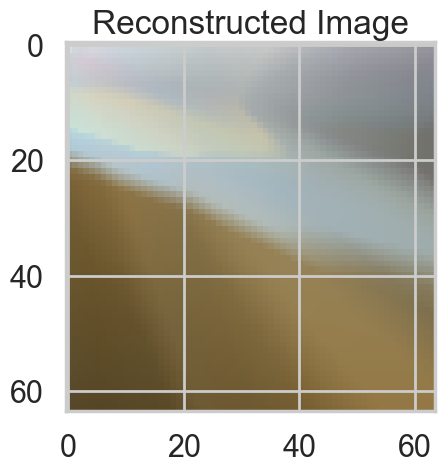

In [ ]:
# 4c.2 and 4c.3

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load image

datadir = "/Users/darian/Desktop/UIUC/Applied ML/HW4/Code/"
im = cv2.imread(datadir + 'scotland_photo_resized.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = im / 255.0  # Normalize to [0, 1]


class MLP(nn.Module):
    def __init__(self, input_size=2, output_size=3, hidden_size=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x


def train_MLP_RGB(train_loader, lr, num_epochs):
  '''
  Train a MLP
  Input: train_loader and val_loader are dataloaders for the training and
  val data, respectively. lr is the learning rate, and the network will
  be trained for num_epochs epochs.
  Output: return a trained MLP
  '''
  # TODO: fill in all code

  input_size = 2    # xy coord
  hidden_size = 128
  output_size = 3   # RGB vals

  mlp = MLP(input_size, output_size).to(device)
  loss_func = nn.MSELoss()
  optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)

  training_losses = []
  validation_losses = []

  for epoch in range(num_epochs):
      mlp.train()
      running_loss = 0.0
      for inputs, labels in tqdm.tqdm(train_loader):
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = mlp(inputs)
          loss = loss_func(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
      print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

  return mlp

device = torch.device("mps")

def positional_encoding(x, y, d_model):
    
    # x: x-coordinate of the pixel
    # y: y-coordinate of the pixel
    # d_model: The dimension of the encoding
    # returns sinusoidal encoded vector for the position
    
    position = np.array([x, y])
    pe = np.zeros(d_model)
    for pos in range(d_model // 2):
        div_term = np.exp(pos * -np.log(10000.0) / (d_model // 2))
        pe[2 * pos] = np.sin(position[0] * div_term) + np.sin(position[1] * div_term)
        pe[2 * pos + 1] = np.cos(position[0] * div_term) + np.cos(position[1] * div_term)
    return pe

# prepare dataset with pos enc
d_model = 128 
X_encoded = np.array([positional_encoding(x, y, d_model) for x, y in X])
tensor_x_enc = torch.FloatTensor(X_encoded)

# Prepare dataset
h, w, _ = im.shape
X_encoded = np.array([(x, y) for x in range(w) for y in range(h)])
y = im.reshape(-1, 3)
tensor_x_enc = torch.FloatTensor(X)
tensor_y = torch.FloatTensor(y)
dataset = TensorDataset(tensor_x_enc, tensor_y)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Load image

datadir = "/Users/darian/Desktop/UIUC/Applied ML/HW4/Code/"
im = cv2.imread(datadir + 'scotland_photo_resized.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = im / 255.0  # Normalize to [0, 1]

# Prepare dataset
h, w, _ = im.shape
X = np.array([(x, y) for x in range(w) for y in range(h)])
y = im.reshape(-1, 3)
tensor_x = torch.FloatTensor(X)
tensor_y = torch.FloatTensor(y)
dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

mlp = train_MLP_RGB(train_loader, lr=0.01, num_epochs=100)

# Predict and reconstruct image
mlp.eval()
with torch.no_grad():
    pred = mlp(tensor_x.to(device)).cpu().numpy()
pred_img = pred.reshape(h, w, 3)

# Display the reconstructed image
plt.imshow(pred_img)
plt.title("Reconstructed Image")
plt.show()



In [ ]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/My Drive/CS441/24SP/hw2" # @param {type:"string"}
NOTEBOOK_NAME = "CS441_SP24_HW2_Solution.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")